In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

## Abriendo el CSV


In [2]:
shark = pd.read_csv('./GSAF5.csv', engine="python")

display(shark.head())


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


Seleccionando las columnas que me pueden interesar en primera instancia para mi análisis.

Comrpobando los valores nulos de cada Serie.

In [3]:

shark_file = shark [["Year", "Type", "Activity", "Sex ", "Fatal (Y/N)"]]


shark_file.isnull().sum()

Year             0
Type             0
Activity       527
Sex            567
Fatal (Y/N)     19
dtype: int64

## RE-CATEGORIZANDO LAS COLUMNAS NECESARIAS


### Columna Fatal (Y/N)

Concierto a nulo los valores extraños y a 'NO' los valores mal introducidos

In [4]:
def transform_fatal(x):
    if x=='UNKNOWN' or x=='#VALUE!': return np.nan
    elif x==' N' or x=='n' or x=='N 'or x=='F' or x=='N': return 'NO'
    elif x=='Y': return 'YES'


Utilizo .apply para ejecutar la función en la columna deseada

In [5]:

shark_file['Fatal (Y/N)']=shark_file['Fatal (Y/N)'].apply(transform_fatal)
shark_file['Fatal (Y/N)'].value_counts()	#Comprobando

/home/jjespper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NO     4326
YES    1552
Name: Fatal (Y/N), dtype: int64

### Columna Sexo
Convierto a 'M' los valores mal introducidos

Convierto a nulo los valores extraños

In [6]:
def transform_sex(x):
    if x=='M ' or x=='N' or x=="M": return 'M'
    elif x=='F': return "F" 
    elif x=="lli" or x==".": return np.nan

Utilizo .apply para ejecutar la función

In [7]:
shark_file['Sex ']=shark_file['Sex '].apply(transform_sex)
shark_file["Sex "].value_counts()	#Comprobando


/home/jjespper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


M    4838
F     585
Name: Sex , dtype: int64

### Columna Type
Convierto a nulo estas dos categorias ya que no aportan nada en mi análisis

Convierto a nulo los valores categorizados como inválidos

Convierto a 'Unprovoked' la categoría 'Sea Disaster' puesto que son accidentes que no han sido provocados.

In [8]:
def transform_type(x):
    if x=='Boat' or x=='Boating' : return np.nan 
    elif x=='Invalid': return np.nan
    elif x=='Provoked': return 'Provoked'
    elif x=='Unprovoked' or x=="Sea Disaster" : return 'Unprovoked' 

Utilizo .apply para ejecutar la función

In [9]:
shark_file['Type']=shark_file['Type'].apply(transform_type)
shark_file["Type"].value_counts()	#Comprobando

/home/jjespper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Unprovoked    4606
Provoked       557
Name: Type, dtype: int64

### Columna Activity
Con esto quiero diferenciar las actividades según el riesgo que pueden llegar a conllevar

In [10]:
def categorizar_act(x):
    x = str(x)
    if (re.search('\w*([Ss]hark)|([Dd]iv)\w*', x)): 
        return 'Riesgo Alto'
    elif (re.search ('\w*([Ss]urf)|([Bb]oard)|([Ff]ell)|([Ll]obste)|([Cc]ano)|([Rr]ow)|([Kk]ayak)|([Bb]oat)\w*', x)):
        return 'Riesgo Medio'
    elif (re.search('\w*([Bb]ath)|([Ss]wim)|([Ss]nork)|([Ff]loat)|([Ww]ad)|([Ss]tand)|([Tt]read)|([Ww]alk)|([Ff]ish)\w*', x)):
        return 'Riesgo Bajo'
    

Utilizo .apply para ejecutar la función

In [11]:
shark_file['Activity']=shark_file['Activity'].apply(categorizar_act)
shark_file['Activity'].value_counts()

/home/jjespper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Riesgo Bajo     2558
Riesgo Medio    1678
Riesgo Alto      799
Name: Activity, dtype: int64

## LIMPIANDO NULOS



In [12]:
shark_file['Type'].value_counts()

Unprovoked    4606
Provoked       557
Name: Type, dtype: int64

#### Columna 'Fatal (Y/N)', 'Sex', 'Type'

In [13]:

shark_1= shark_file.dropna(subset=['Fatal (Y/N)', 'Sex ', 'Type'])
shark_1.isnull().sum()	#Comprobando 
shark_1.shape	#Viendo con cuantas filas me quedo

(4829, 5)

## FILTRADO DE COLUMNAS

Columnas seleccionadas

Seleccionando columnas que finalmente voy a utilizar.

In [14]:
shark_w = shark_1 [["Type", "Sex ", "Fatal (Y/N)", "Year", "Activity"]] 
shark_w.head() #Comprobando


,Type,Sex,Fatal (Y/N),Year,Activity
0,Unprovoked,M,NO,2016,Riesgo Medio
1,Unprovoked,M,NO,2016,Riesgo Medio
2,Unprovoked,M,NO,2016,Riesgo Medio
3,Unprovoked,M,NO,2016,Riesgo Medio
4,Unprovoked,M,NO,2016,Riesgo Medio


### Filtrado de datos (últimos 100 años)

In [15]:

shark_w_year = shark_w.query('2001 <= Year <= 2016')

## DIVIDIENDO EN DATAFRAMES

Solo Mujeres

In [16]:

shark_w_year_female = shark_w_year.drop(shark_w_year[shark_w_year["Sex "]== 'M'].index)

Solo Hombres

In [17]:

shark_w_year_male = shark_w_year.drop(shark_w_year[shark_w_year["Sex "]== 'F'].index)

Solo No Fatales

In [18]:

shark_w_year_nodied = shark_w_year.drop(shark_w_year[shark_w_year["Fatal (Y/N)"]== 'YES'].index)

Solo Fatales

In [19]:

shark_w_year_yesdied = shark_w_year.drop(shark_w_year[shark_w_year["Fatal (Y/N)"]== 'NO'].index)

Solo No Provocados

In [20]:

shark_w_year_unprovoked = shark_w_year.drop(shark_w_year[shark_w_year["Type"]== 'Provoked'].index)

Solo Provocados

In [21]:

shark_w_year_provoked = shark_w_year.drop(shark_w_year[shark_w_year["Type"]== 'Unprovoked'].index)

Solo Mujeres No Fatal

In [22]:

shark_w_year_nodied_female = shark_w_year_nodied.drop(shark_w_year_nodied[shark_w_year_nodied['Sex ']== 'M'].index)

Solo Hombres No Fatal

In [23]:

shark_w_year_nodied_male = shark_w_year_nodied.drop(shark_w_year_nodied[shark_w_year_nodied['Sex ']== 'F'].index)

Solo Mujeres Si Fatal

In [24]:

shark_w_year_yesdied_female = shark_w_year_yesdied.drop(shark_w_year_yesdied[shark_w_year_yesdied['Sex ']== 'M'].index)

Solo Hombres Si Fatal

In [25]:

shark_w_year_yesdied_male = shark_w_year_yesdied.drop(shark_w_year_yesdied[shark_w_year_yesdied['Sex ']== 'F'].index)


# GRÁFICAS DE DISTRIBUCIÓN


## Sexo

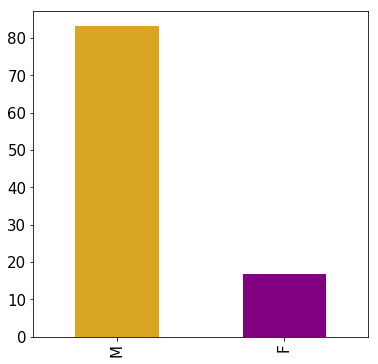

In [27]:

(shark_w_year['Sex '].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['goldenrod', 'purple'])


##### Los hombres han sufrido x5 accidentes que las mujeres.

## Tipos de accidentes (Provocado/No Provocado)

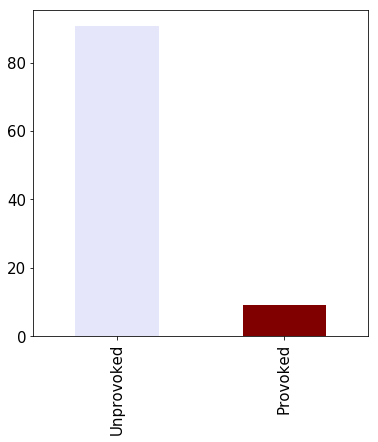

In [28]:

(shark_w_year['Type'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['lavender', 'maroon'])


##### Más del 90% de los accidentes han sido no provocados.

## Tipos de accidentes en hombres 

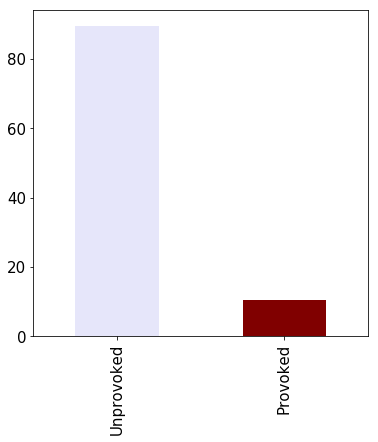

In [29]:

(shark_w_year_male['Type'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['lavender', 'maroon'])


##### En los hombres prácticamente se mantiene esta misma proporción, aumenta algo más de un punto porcentual.

## Tipos de accidentes en mujeres

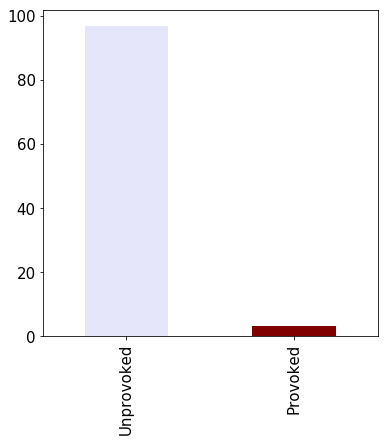

In [30]:

(shark_w_year_female['Type'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['lavender', 'maroon'])


##### Las mujeres tienen pocos accidentes no provocados

## Mortalidad en hombres

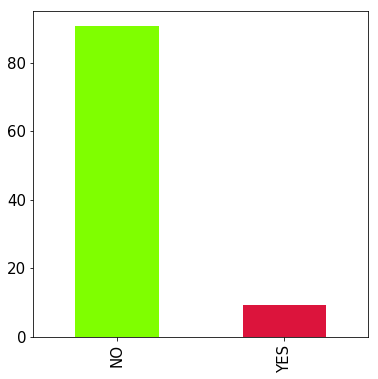

In [31]:

(shark_w_year_male['Fatal (Y/N)'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['chartreuse', 'crimson'])


## Mortalidad en mujeres

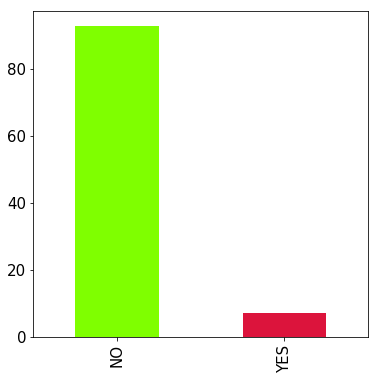

In [32]:

(shark_w_year_female['Fatal (Y/N)'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['chartreuse', 'crimson'])


##### Los hombres tienen más accidentes mortales que las mujeres

## Tipos de accidentes en mujeres que no han muerto

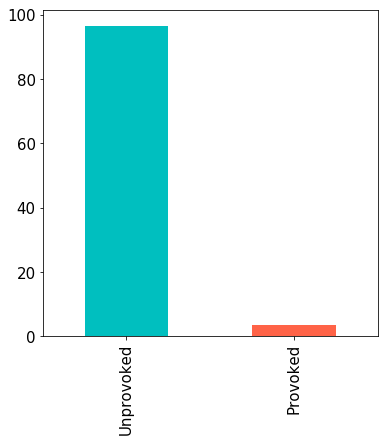

In [33]:

(shark_w_year_nodied_female['Type'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['c', 'tomato'])


##### Pocas mujeres que han sufrido un ataque no mortal provocaron el accidente

## Tipos de accidentes en hombres que no han muerto

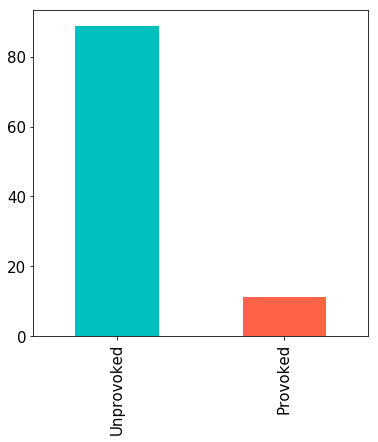

In [34]:

(shark_w_year_nodied_male['Type'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['c', 'tomato'])


##### En cambio los hombres han provocado más accidentes no mortales

## Tipos de accidentes en mujeres que si han muerto

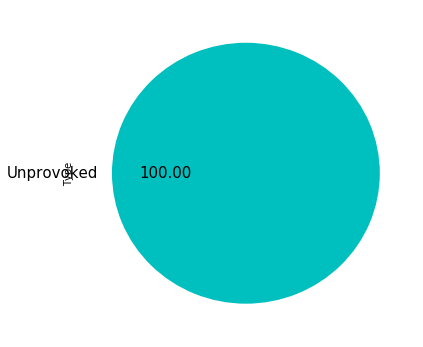

In [36]:

(shark_w_year_yesdied_female['Type'].value_counts(normalize=True)*100).plot.pie(autopct='%.2f', fontsize=15, figsize=[6,6], colors=['c', 'tomato'])


##### El 100% de las muejeres que murieron no habían provocado el ataque

## Tipos de accidentes en hombres que si han muerto

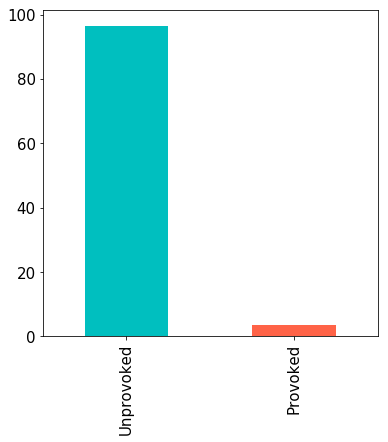

In [37]:

(shark_w_year_yesdied_male['Type'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['c', 'tomato'])


##### Algo más del 3% de los hombres que muerieron si habían provocado el accidente

## Riesgo (actividad) en mujeres 

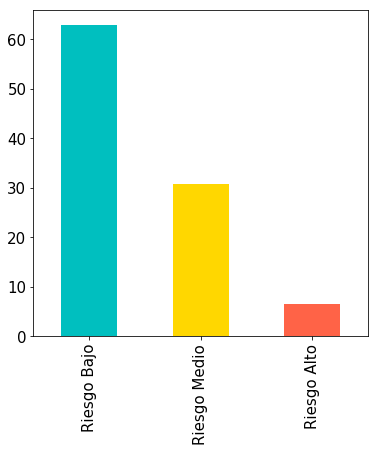

In [38]:

(shark_w_year_female['Activity'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['c', 'gold', 'tomato'])


##### Pocas mujeres que sufrieron un ataque realizaban actividades de alto riesgo

## Riesgo (actividad) en hombres

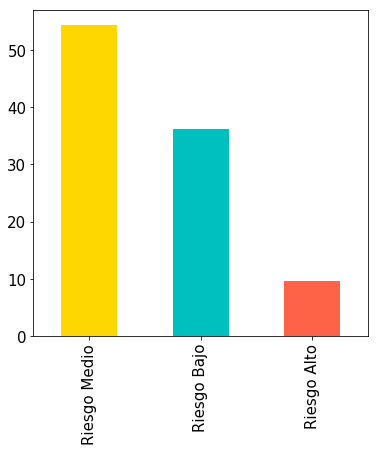

In [39]:

(shark_w_year_male['Activity'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['gold', 'c', 'tomato'])


##### La mayoría de los hombres que sufireron un ataque realizaban actividades de alto/medio riesgo

## Riesgo (actividad) en accidentes no fatales

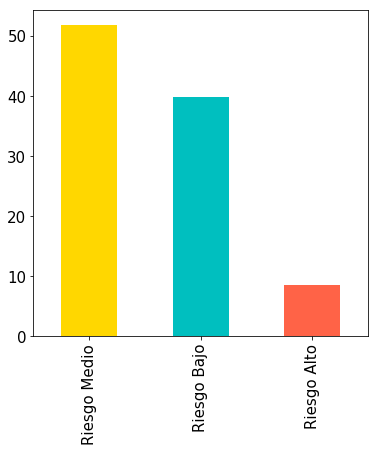

In [40]:

(shark_w_year_nodied['Activity'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['gold', 'c', 'tomato'])

##### Las personas (hombres y mujeres) que no muerieron no realizaban muchas actividades de riesgo

## Riesgo (actividad) en accidentes si fatales

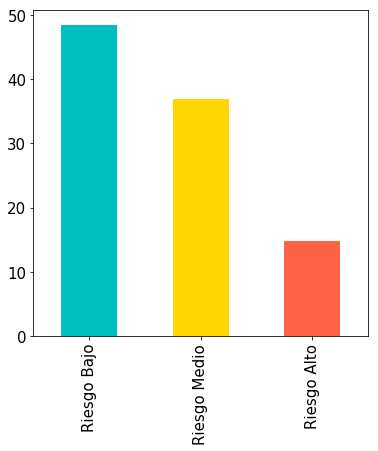

In [41]:

(shark_w_year_yesdied['Activity'].value_counts(normalize=True)*100).plot.bar(fontsize=15, figsize=[6,6], colors=['c', 'gold', 'tomato'])

##### Las personas que muerieron realizaban más actividades de alto/medio riesgo que de bajo riesgo